In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('jena_climate_2009_2016.csv')

In [3]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000,420551.000000
mean,989.212776,9.450147,283.492743,4.955854,76.008259,13.576251,9.533756,4.042412,6.022408,9.640223,1216.062748,1.702224,3.056555,174.743738
std,8.358481,8.423365,8.504471,6.730674,16.476175,7.739020,4.184164,4.896851,2.656139,4.235395,39.975208,65.446714,69.016932,86.681693
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.900000
50%,989.580000,9.420000,283.470000,5.220000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.790000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.490000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,28.490000,23.500000,360.000000


In [4]:
df=df[5::6]

In [5]:
df.index=pd.to_datetime(df['Date Time'],format='%d.%m.%Y %H:%M:%S')

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
scaler = MinMaxScaler()
df['T (degC)'] = scaler.fit_transform(df[['T (degC)']])

<Axes: xlabel='Date Time'>

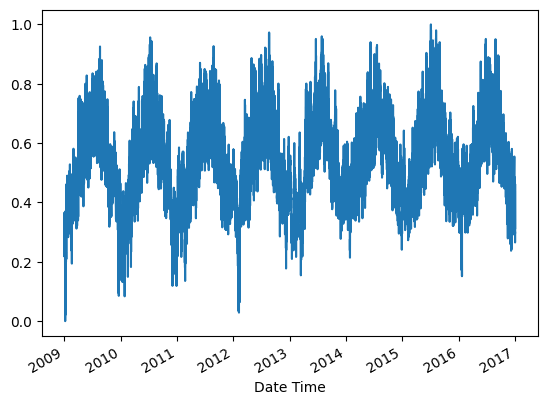

In [8]:
df['T (degC)'].plot()

In [9]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X, y = [], []
    for i in range(len(df_as_np) - window_size):
        X.append(df_as_np[i:i+window_size])
        y.append(df_as_np[i+window_size])
    return np.array(X), np.array(y)


In [10]:
window_size = 5 
X, y = df_to_X_y(df['T (degC)'], window_size)

print(X.shape)
print(y.shape)

(70086, 5)
(70086,)


In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [13]:
X_train=X_train.reshape(-1,window_size,1)
X_test = X_test.reshape(-1, window_size, 1)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [21]:
model=Sequential()

model.add(LSTM(64,activation='relu',return_sequences=True,input_shape=(window_size,1)))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
early_stop=EarlyStopping(monitor='val_loss',patience=20)

In [35]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20,batch_size=32,callbacks=[early_stop],verbose=-1)

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20


In [ ]:
losses=pd.DataFrame(model.history.history)

<Axes: >

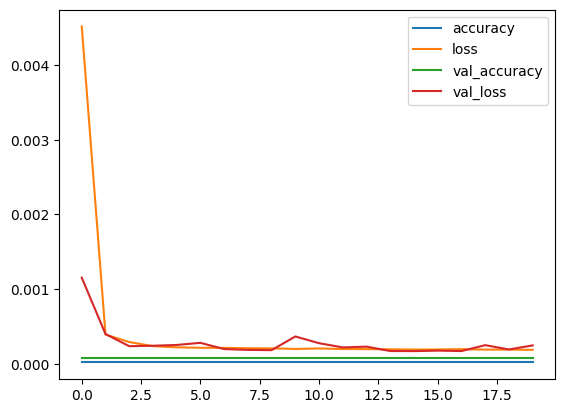

In [39]:
losses.plot()

In [42]:
y_pred=model.predict(X_test)

439/439 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step


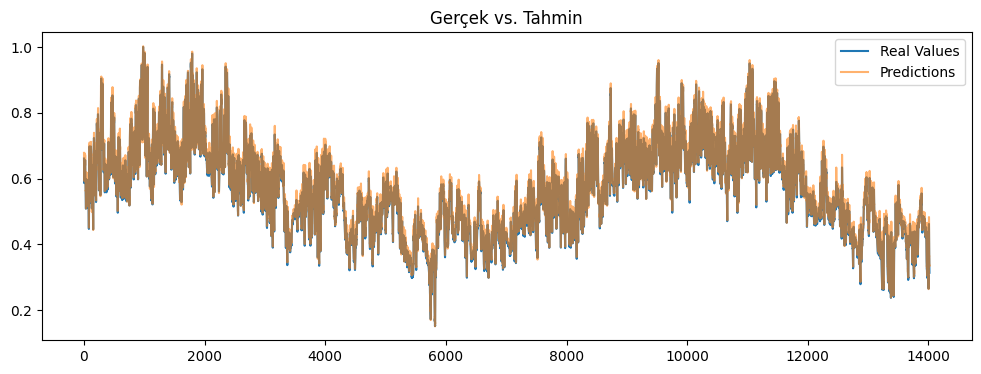

In [56]:
plt.figure(figsize=(12, 4))
plt.plot(y_test, label="Real Values")
plt.plot(y_pred, label="Predictions",alpha=0.6)
plt.legend()
plt.title("Gerçek vs. Tahmin")
plt.show()

In [ ]:
train_predictions = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Predictions':train_predictions, 'Real Values':y_train})
train_results

1753/1753 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step


,Train Predictions,Actuals
0,0.220382,0.218021
1,0.222528,0.226349
2,0.239212,0.244171
3,0.265564,0.251499
4,0.268717,0.261825
...,...,...
56063,0.681545,0.675050
56064,0.690200,0.702199
56065,0.726908,0.696036
56066,0.705423,0.686542


In [28]:
from sklearn.metrics import mean_squared_error

In [58]:
mean_squared_error(y_test,y_pred)

0.0002465421749803474

In [18]:
from tensorflow.keras.layers import GRU

In [20]:
GRU_model=Sequential()

GRU_model.add(GRU(64,activation='relu',return_sequences=True,input_shape=(window_size,1)))
GRU_model.add(GRU(32,activation='relu'))
GRU_model.add(Dense(1))

GRU_model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

c:\Users\gokal\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
GRU_model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=32,epochs=20,callbacks=[early_stop])

Epoch 1/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 4.3619e-06 - loss: 0.0134 - val_accuracy: 7.1337e-05 - val_loss: 2.4172e-04
Epoch 2/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 2.7420e-05 - loss: 2.3581e-04 - val_accuracy: 7.1337e-05 - val_loss: 1.8286e-04
Epoch 3/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 7.3403e-05 - loss: 2.1108e-04 - val_accuracy: 7.1337e-05 - val_loss: 1.8841e-04
Epoch 4/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0958e-05 - loss: 2.0688e-04 - val_accuracy: 7.1337e-05 - val_loss: 2.1836e-04
Epoch 5/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 2.3512e-07 - loss: 2.1626e-04 - val_accuracy: 7.1337e-05 - val_loss: 1.8147e-04
Epoch 6/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 4.1043e-06 - loss: 2.0078e-04 - val_accuracy: 7.1337e-05 - val_loss: 1.8289e-04
Epoch 7/20
1753/1753 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 3.9558e-05 - loss: 1.9894e-04 - val_accuracy: 7.1337e-05 - val

In [23]:
losses=pd.DataFrame(GRU_model.history.history)

<Axes: >

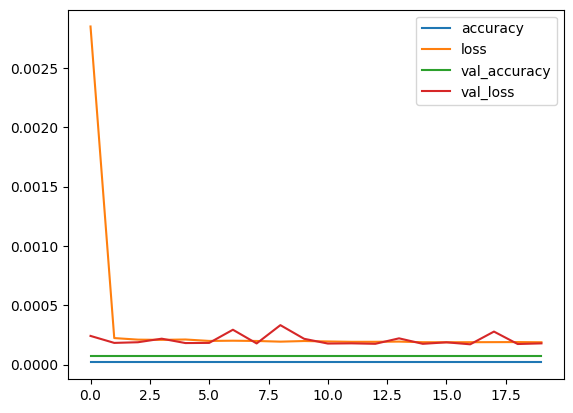

In [24]:
losses.plot()

In [26]:
GRU_y_pred=GRU_model.predict(X_test)

439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step


In [29]:
mean_squared_error(GRU_y_pred,y_test)

0.00017885971788190192